# Computer Vision Demo
## Practical Implementation of Image Classification with PyTorch using Fashion MNIST Dataset

Created by [Murilo Gustineli](https://murilogustineli.com/)

**Run the Computer Vision Demo in a colab notebook**

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/murilogustineli/computer-vision-demo/blob/main/cv_demo.ipynb)

**References:**
- [TensorFlow tutorial: Basic Image Classification](https://www.tensorflow.org/tutorials/keras/classification?linkId=9317518)
- [Training with PyTorch documentation](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html)
- [Fashion MNIST GitHub repo](https://github.com/zalandoresearch/fashion-mnist)
- [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition)

Welcome to this practical implementation, where we delve into the world of computer vision using PyTorch.

Our goal is to develop a practical understanding of Convolutional Neural Networks (CNNs) by implementing a model that can classify different types of clothing. This demo is designed for learners at all levels, so don't worry if some concepts seem new. We'll walk through each step of the process, explaining the key ideas and code details along the way.

In [1]:
# PyTorch
import torch

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# Check if cuda is available
cuda_availability = torch.cuda.is_available()
print(f"PyTorch version: {torch.__version__}")
print(f"Cuda availability: {cuda_availability}")

# Auto-reloading external modules
# See http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

PyTorch version: 2.1.2
Cuda availability: False


## 1. The Fashion MNIST dataset

In this demo, we use the `Fashion MNIST` dataset, a modern alternative to the classic [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset traditionally used for handwriting recognition. 

Fashion MNIST comprises 70,000 grayscale images, each 28x28 pixels, distributed across 10 different clothing categories. These images are small, detailed, and varied enough to challenge our model while being simple enough for straightforward processing and quick training times.

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

### 1.1 Dataset Structure

The dataset is split into two parts:

- **Training Set:** This includes `train_images` and `train_labels`. These are the arrays that our model will learn from. The model sees these images and their corresponding labels, adjusting its weights and biases to reduce classification error.

- **Test Set:** This comprises `test_images` and `test_labels`. These are used to evaluate how well our model performs on data it has never seen before. This is crucial for understanding the model's generalization capability.

### 1.2 Understanding the Data

Each image in the dataset is a 28x28 NumPy array. The pixel values range from 0 to 255, with 0 being black, 255 being white, and the various shades of gray in between. The labels are integers from 0 to 9, each representing a specific category of clothing.

**Class Names:**

The dataset doesn't include the names of the clothing classes, so we will manually define them for clarity when visualizing our results. Here's the mapping:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>


In the following sections, we will load and preprocess this data, design and train a CNN, and finally evaluate its performance on the test set. Let's get started!


In [2]:
# Defining class names
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot',
]

## 2. Loading the dataset

Let's load the Fashion MNIST dataset directly from PyTorch:

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from IPython import get_ipython

# Check if running on Google Colab
if 'google.colab' in str(get_ipython()):
    data_dir = '/content/FashionMNIST_data/'
else:
    data_dir = './FashionMNIST_data/'  # Relative path for local execution

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Seed for reproducibility
torch.manual_seed(7)

# Create training and validation datasets
trainset = datasets.FashionMNIST(data_dir, download=True, train=True, transform=transform)
validset = datasets.FashionMNIST(data_dir, download=True, train=False, transform=transform)

# Create data loaders for our datasets
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
validloader = DataLoader(validset, batch_size=32, shuffle=True)

# Report split sizes
print('Training set has {} instances'.format(len(trainset)))
print('Validation set has {} instances'.format(len(validset)))

Training set has 60000 instances
Validation set has 10000 instances


**Defining Transformations:**

- `transforms.ToTensor()`: Converts the images into PyTorch tensors and scales the pixel values to the range [0, 1].

- `transforms.Normalize((0.5,), (0.5,))`: Normalizes the tensor images so that each pixel value is centered around 0 and falls within the range [-1, 1]. This normalization helps in stabilizing the learning process and often leads to faster convergence in deep learning models.

### 2.1 Using DataLoader

The `DataLoader` in PyTorch provides batches of data, and you can iterate through these batches to collect all images and labels. This method is memory-efficient and is typically used when dealing with large datasets.

In [4]:
def extract_images_labels(loader):
    images = []
    labels = []
    for batch in loader:
        b_images, b_labels = batch
        images.append(b_images)
        labels.append(b_labels)
    return torch.cat(images, dim=0), torch.cat(labels, dim=0)

# Extracting train and test images and labels
train_images, train_labels = extract_images_labels(trainloader)
valid_images, valid_labels = extract_images_labels(validloader)

**Important Notes:**

- This method will load the entire dataset into memeory, which is fine for small datasets like the Fashion MNIST, but might not be feasible for significantly larger datasets.

- `train_images` and `valid_images` will be tensors containing the image data, and `train_labels` and `valid_labels` will be tensors containing the corresponding labels.

- These tensors can then be used directly for training and evaluation in your models.

## 3. Exploring the data

Before training our model, it's essential to understand the Fashion MNIST dataset's format and structure. This understanding helps in effectively tailoring our model and preprocessing steps.

### 3.1 Understanding the Training Set

**Size and Shape of Training Images:** The shape of the `train_images` tensor provides insight into the number of images and their dimensions.
    
The shape is represented as (N, C, H, W), where:
- N = Number of images
- C = Number of color channels per image (For grayscale images, C = 1)
- H = Height of each image in pixels
- W = Width of each image in pixels

In our dataset, each image is a 28 x 28 pixel grayscale image, so the shape will be (60000, 1, 28, 28), indicating 60,000 images with 1 color channel and 28x28 pixel resolution.

In [5]:
train_images.shape  # Output expected: (60000, 1, 28, 28)

torch.Size([60000, 1, 28, 28])

The "rank" of a tensor refers to the number of dimensions it has. For images represented as tensors, you can find the rank using the `.dim()` method, which returns the number of dimensions in the tensor.

In [6]:
train_images.dim() # Output expected: 4

4

- **Training Labels:** The total number of labels in the training set should match the number of images. Each label corresponds to a category of fashion item.

In [7]:
len(train_labels)   # Output expected: 60000

60000

- **Label Range:** Each label is an integer from 0 to 9, where each number corresponds to a specific category (like T-shirts, trousers, etc.).

In [8]:
train_labels        # Output example: tensor([9, 8, 3, ..., 7, 7, 6])

tensor([9, 8, 3,  ..., 7, 7, 6])

### 3.2 Understanding the Test Set

- **Size and Shape of Test Images:** The test set should have a similar structure but with fewer images, typically used for evaluating the model's performance.


In [9]:
valid_images.shape   # Output expected: (10000, 1, 28, 28)

torch.Size([10000, 1, 28, 28])

- **Test Labels:** The test set contains labels corresponding to each image, used to verify the model's predictions.

In [10]:
len(valid_labels)    # Output expected: 10000

10000

## 4. Data Preprocessing

Before training our neural network, it's crucial to preprocess the data. This involves scaling the pixel values of the images to a standard range, which helps the network learn more efficiently.

### 4.1 Understanding Pixel Values:

- Each image in the Fashion MNIST dataset is represented in grayscale with pixel values ranging from 0 to 255.

- We applied Scaling and Normalization methods so that each pixel value is centered around 0 and falls within the range [-1, 1].

- This normalization is often used in deep learning models as it centers the data around 0, which can lead to faster convergence during training. It can also help mitigate issues caused by different lighting and contrast in images.

- The value `-1` represents black, `1` represents white, and the values in between represent various shades of gray.

Let's inspect the first image in the training set displaying these pixel values:

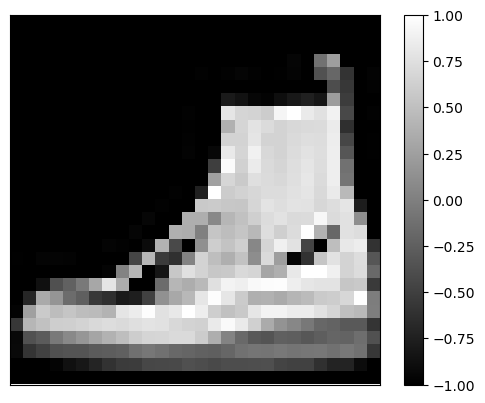

In [11]:
# Plotting firt image
plt.figure()
plt.imshow(train_images[0][0], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

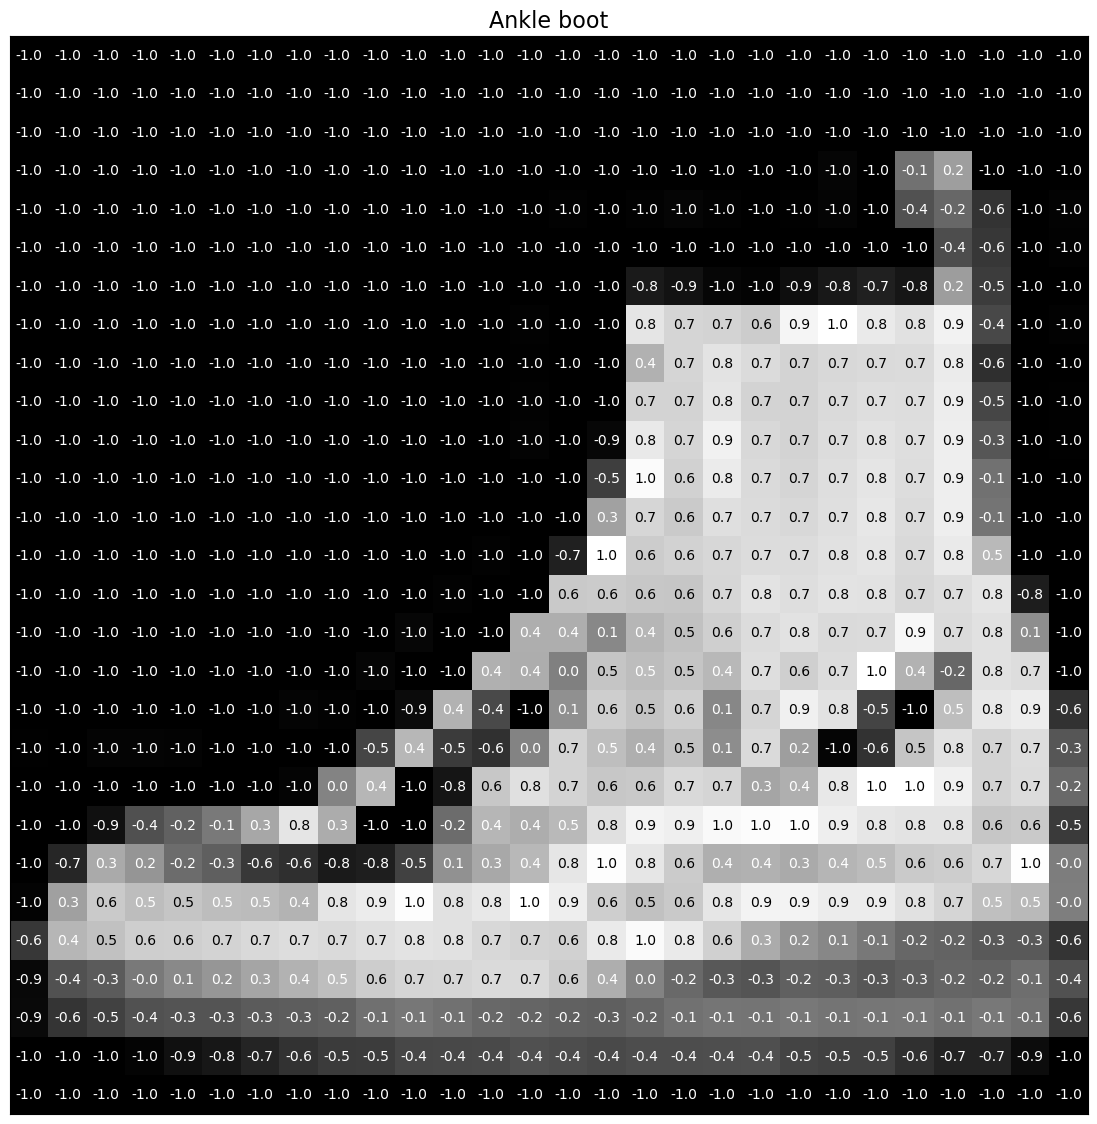

In [12]:
def get_text_color(value:float) -> str:
    """Returns 'white' for dark pixels and 'black' for light pixels."""
    return 'white' if value < 0.5 else 'black'

image_numpy = train_images[0][0].squeeze().numpy()
label = train_labels[0]

# Plotting the image
plt.figure(figsize=(14,14))
plt.imshow(image_numpy, cmap='gray')
plt.title(class_names[label], fontsize=16,)
plt.grid(False)
plt.xticks([])
plt.yticks([])

# Overlaying the pixel values
for i in range(image_numpy.shape[0]):
    for j in range(image_numpy.shape[1]):
        plt.text(j, i, '{:.1f}'.format(image_numpy[i,j]), ha='center', va='center', color=get_text_color(image_numpy[i,j]))
plt.show()

### 4.2 Verifying the Data Format:

- Before building the model, it's a good practice to visualize the data to ensure it's in the correct format. Displaying the first 25 images from the training set can help us confirm that the data is ready for model training.

- Additionally, displaying the class name below each image ensures that the labels correspond correctly to the images:

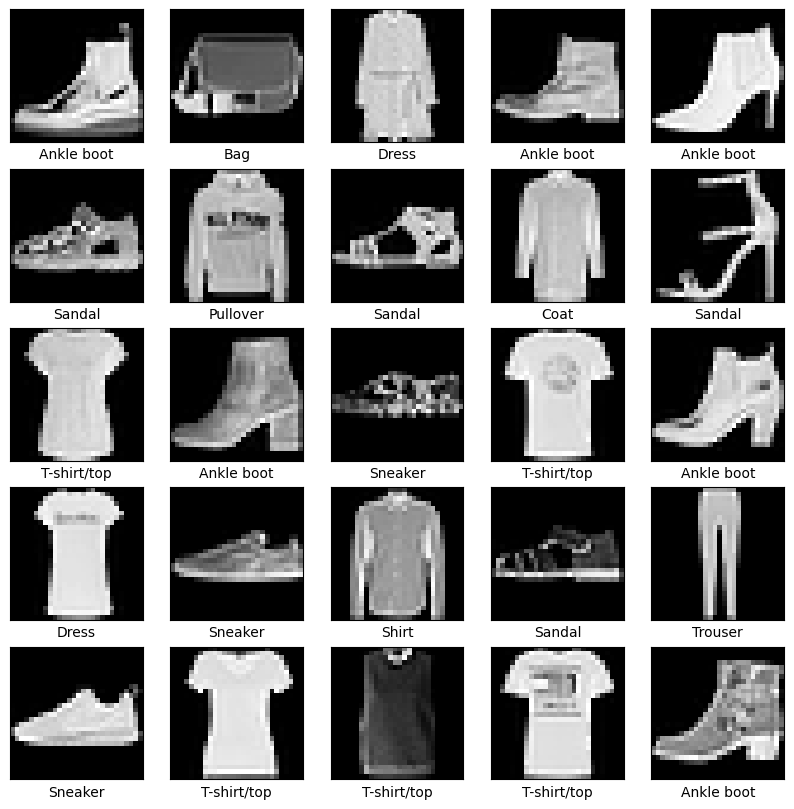

In [13]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i][0], cmap='gray') 
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## 5. Convolutional Neural Networks

In deep learning, especially for tasks like image classification, **Convolutional Neural Networks (CNNs)** are often the architecture of choice. CNNs are designed to automatically and adaptively learn spatial hierarchies of features from input images.

<table>
  <tr><td>
    <img src="https://learnopencv.com/wp-content/uploads/2023/10/Convolutional-Neural-Network.png"
         alt="CNN Architecture"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 2.</b> <a href="https://learnopencv.com/understanding-convolutional-neural-networks-cnn/">Understanding Convolutional Neural Network (CNN): A Complete Guide</a> (by LearnOpenCV).<br/>&nbsp;
  </td></tr>
</table>

### 5.1 Hierarchical Compositionality in CNNs

***Complex features are built from simpler ones.***

In Convolutional Neural Networks (CNNs), the concept of hierarchical compositionality plays a pivotal role. This idea is based on how CNNs learn to recognize and interpret images through layers that understand increasingly complex features:

- **Low-Level Features:** The initial layers of a CNN focus on simple, low-level features such as edges, colors, and basic textures.

- **Mid-Level Features:** As the data progresses through the network, these basic features are combined to form mid-level features, like shapes and specific patterns.

- **High-Level Features:** In the deeper layers, these combinations further evolve into high-level features that represent more complex aspects of the image, such as entire objects or significant parts of them.

<table>
  <tr><td>
    <img src="./figures/Hierarchical-Compositionality.jpg"
         alt="Hierarchical Compositionality"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 3.</b> <a href="https://omscs.gatech.edu/cs-7643-deep-learning">CS 7643: Deep Learning</a> (by Zsolt Kira, Georgia Institute of Technology).<br/>&nbsp;
  </td></tr>
</table>

This hierarchical approach allows CNNs to build a deep understanding of images from simple to complex, making them highly effective for tasks like image classification.

#### Extra Resources:
- **Paper:** [Visualizing and Understanding Convolutional Networks](https://arxiv.org/pdf/1311.2901.pdf)
- **CNN Explainer:** [Learn CNNs in your browser!](https://poloclub.github.io/cnn-explainer/)

### 5.2 CNN Architecture

Let's construct a CNN suitable for the Fashion MNIST dataset using PyTorch's `torch.nn` module. This CNN will consist of convolutional layers for feature extraction followed by fully connected layers for classification.

Here's how we can structure our CNN:

<!--
### Build the Model

Setting up the Layers

In deep learning, a model is typically constructed from layers. Layers are the fundamental building blocks that process input data and extract relevant features. In PyTorch, layers are implemented using various classes provided in torch.nn module.

Let's construct a simple Convolutional Neural Network (CNN) suitable for the Fashion MNIST dataset. Our network will consist of convolutional layers followed by fully connected layers.

1. **Flattening:** The images in the Fashion MNIST dataset are 2D (28x28 pixels), but to feed them into a fully connected layer, we need to flatten them into 1D vectors. This is done by reshaping the tensor.

2. **Fully Connected Layers:** After flattening the images, we'll pass the data through fully connected (dense) layers. The first dense layer will have 128 neurons and use ReLU (Rectified Linear Unit) as the activation function. The final dense layer will output the class logits, one for each of the 10 classes in the dataset.

Here's the PyTorch code for the model:

import torch.nn as nn
import torch.nn.functional as F

class NeuralNetClassifier(nn.Module):
    def __init__(self):
        super(NeuralNetClassifier, self).__init__()
        # Define layers
        self.fc = nn.Sequential(
            nn.Flatten(),               # Flatten the 2D 28x28 image into a 1D vector of 784 pixels
            nn.Linear(28*28, 128),      # First fully connected layer: 784 inputs, 128 outputs
            nn.BatchNorm1d(128),        # Batch normalization for the first fully connected layer
            nn.ReLU(inplace=True),      # ReLU activation function
            nn.Linear(128, 10),         # Second fully connected layer: 128 inputs, 10 outputs (classes)
            nn.BatchNorm1d(10),         # Batch normalization for the second fully connected layer
            nn.ReLU(inplace=True),      # Final ReLU activation function
        )

    def forward(self, x):
        x = self.fc(x)                  # Forward pass through the sequential container
        return x

# Create the model instance
model = NeuralNetClassifier()

#### Comments on the Model:

- **Sequential Container:** The `nn.Sequential` container simplifies the model definition by automatically arranging the layers in the order they are passed. It's a convenient way to stack layers and activations.

- **Fully Connected Layers (nn.Linear):**
    - The first `nn.Linear(28*28, 128)` layer takes the flattened input (784 features) and transforms it into a hidden layer with 128 neurons.
    - The second `nn.Linear(128, 10)` layer further transforms these 128 features into 10 outputs, corresponding to the 10 classes in the Fashion MNIST dataset.

- **Batch Normalization:** `nn.BatchNorm1d` is used after each fully connected layer. Batch normalization standardizes the inputs to a layer for each mini-batch. This stabilizes the learning process and significantly improves the training of deep networks by reducing internal covariate shift.

- **ReLU Activation:** `ReLU(inplace=True)` is used as an activation function. The `inplace=True` parameter is a memory optimization. It allows the modification of input data directly, which can save memory by avoiding allocating of additional space for outputs.
-->

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        # Convolutional layers using Sequential
        self.conv_layers = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),   # 32 filters, 3x3 kernel, stride 1, padding 1
            nn.ReLU(inplace=True),                                  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),                  # 2x2 Max pooling with stride 2

            # Second convolutional layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 64 filters, 3x3 kernel, stride 1, padding 1
            nn.ReLU(inplace=True),                                  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),                  # 2x2 Max pooling with stride 2
        )

        # Fully connected layers using Sequential
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                                           # Flatten the output of conv layers
            nn.Linear(64 * 7 * 7, 128),                             # Fully connected layer with 128 neurons
            nn.ReLU(inplace=True),                                  # ReLU activation
            nn.Linear(128, 10)                                      # Output layer with 10 neurons for 10 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)                                     # Pass through conv layers
        x = self.fc_layers(x)                                       # Pass through fully connected layers
        return x

# Create the model instance
model = CNNClassifier()

#### Architecture explanation:

- **Convolutional Layers:** The model starts with two sets of convolutional layers, each followed by a ReLU activation and a max pooling layer. The first `Conv2d` layer takes a single-channel (grayscale) image and applies 32 filters. The second `Conv2d` layer increases the depth to 64 filters.

- **ReLU Activation:** After each convolutional layer, a ReLU activation function is used. It introduces non-linearity, allowing the model to learn more complex patterns.

- **Max Pooling:** Each max pooling layer (`MaxPool2d`) reduces the spatial dimensions of the feature map by half, helping in reducing the computation and controlling overfitting.

- **Fully Connected Layers:** The output from the convolutional layers is flattened into a 1D vector and then passed through two fully connected layers. The first linear layer reduces the dimension to 128, and the second linear layer produces the final output corresponding to the 10 classes.

This architecture, structured using the `nn.Sequential` container, offers a clear and compact way to define a CNN in PyTorch. The model is now ready to be trained with the Fashion MNIST dataset.

### 5.3 Defining the Loss Function and Optimizer

Before training, the model requires a few additional settings, including an optimizer and a loss function:

1. **Optimizer:** The optimizer is responsible for updating the model parameters based on the computed gradients. It's crucial for the convergence of the training process.

2. **Loss Function:** The loss function measures the discrepancy between the model's predictions and the actual labels. During training, we aim to minimize this loss.

Here's how you set up these components in PyTorch:

In [15]:
import torch.optim as optim

# Set the loss function
loss_fn = nn.CrossEntropyLoss()

# Set the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Explanation:

- **Cross-Entropy Loss:** We use `nn.CrossEntropyLoss` for multi-class classification. This loss function combines nn.LogSoftmax and nn.NLLLoss in one single class. It is suitable for classification tasks with C classes.

- **Adam Optimizer:** `optim.Adam` is used as the optimizer. It's a popular choice due to its effectiveness in handling sparse gradients and adapting the learning rate during training.

- **Learning Rate (lr):** This is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. Here, it's set to 0.001.

## 6. Training the Model

Having defined the model architecture and set up the loss function and optimizer, we now move to one of the most crucial stages in building a machine learning model -- **training**. 

Training a model in deep learning involves feeding it data, letting it make predictions, and then adjusting the model parameters (weights) based on the error in its predictions. This process is repeated iteratively and is essential for the model to learn from the data.

- **Documentation:** [Training with PyTorch](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html)

### 6.1 The Training Loop

The core of model training in PyTorch is the training loop. During each iteration (or epoch) of the loop, the model makes predictions (a forward pass), calculates the error (loss), and updates its parameters (a backward pass). Here's a basic outline of what this process involves:

1. **Forward Pass:** The model processes the input data and makes predictions.

2. **Compute Loss:** The discrepancy between the model's predictions and the actual labels is calculated using the loss function.

3. **Backward Pass:** Backpropagation is performed to calculate the gradients of the loss with respect to each model parameter.

4. **Update Model Parameters:** The optimizer updates the model parameters using the computed gradients.

#### Training Function
Unlike TensorFlow's Keras API, which provides high-level functions like `model.fit` and `model.evaluate`, PyTorch requires you to explicitly define the training loop and the evaluation process. This approach gives you more control and flexibility but also requires more code.

First, we define a function to encapsulate the training logic for one epoch. This function will handle the forward and backward passes, loss computation, and parameter updates:
<!-- Here's how you can implement the training loop in PyTorch: -->

In [16]:
def train_one_epoch(model, trainloader, optimizer, loss_fn, epoch_index, tb_writer):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    total_batches = len(trainloader)
    log_interval = max(1, total_batches // 10)  # Log 10 times per epoch or at least once

    for i, data in enumerate(trainloader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero the gradients to ensure they aren't accumulated
        optimizer.zero_grad()  

        # Forward pass
        outputs = model(inputs)          # Make predictions for this batch
        loss = loss_fn(outputs, labels)  # Compute the loss

        # Backward pass and optimization
        loss.backward()     # Compute the gradients
        optimizer.step()    # Adjust learning weigths

        # Accumulate loss
        running_loss += loss.item()
        if i % log_interval == log_interval - 1:        # Adjusted logging condition
            average_loss = running_loss / log_interval  # Average loss per batch in this set
            print(f"  batch {i+1} loss: {average_loss}")
            tb_x = epoch_index * total_batches + i + 1
            tb_writer.add_scalar('Loss/train', average_loss, tb_x)
            running_loss = 0.0

    return average_loss

#### Validation Function

Next, we add a function to perform validation after each training epoch. This function will evaluate the model on a separate validation dataset:

In [17]:
import os

# Model validation
def validate(model, validloader, loss_fn):
    model.eval()  # Set the model to evaluation mode
    running_vloss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in validloader:
            outputs = model(inputs)
            vloss = loss_fn(outputs, labels)
            running_vloss += vloss.item()

    average_vloss = running_vloss / len(validloader)
    return average_vloss

#### Early Stopping

Early Stopping is a technique that helps prevent overfitting by terminating the training when the model starts to learn noise or irrelevant patterns in the training data.

In [18]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        """
        Early stops the training if validation loss doesn't improve after a given patience.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Initialize the early stopping object
early_stopping = EarlyStopping(patience=3, min_delta=0.01)

#### Training and Validation Loop

With these functions in place, we can structure the overall training and validation loop:

In [19]:
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

def train_model(model, trainloader, validloader, optimizer, loss_fn, num_epochs=10, save_model=True):
    """
    Runs the training and validation loop for the given model.
    
    Args:
        model (nn.Module): The neural network model to be trained.
        trainloader (DataLoader): DataLoader for the training dataset.
        validloader (DataLoader): DataLoader for the validation dataset.
        optimizer (torch.optim.Optimizer): Optimizer for the model.
        loss_fn: Loss function to use for training.
        num_epochs (int): Number of epochs for training. Default is 10.
        save_model (bool): Flag to save the model if validation loss improves. Default is True.
    """
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
    train_losses = []
    val_losses = []
    EPOCHS = num_epochs
    best_vloss = 1_000_000.

    for epoch in range(EPOCHS):
        print(f'EPOCH {epoch + 1}/{EPOCHS}')

        # Training
        avg_loss = train_one_epoch(model, trainloader, optimizer, loss_fn, epoch, writer)
        # print(f'Training Loss: {avg_loss:.4f}')

        # Validation
        avg_vloss = validate(model, validloader, loss_fn)
        print(f'LOSS train: {avg_loss:.4f} -- valid: {avg_vloss:.4f}')
        # print(f'Validation Loss: {avg_vloss:.4f}')
        
        # Log the running loss averaged per batch for both training and validation
        writer.add_scalars(
            'Training vs. Validation Loss',
            {'Training': avg_loss, 'Validation': avg_vloss },
            epoch+1
        )
        writer.flush()

        # Append average losses after each epoch
        train_losses.append(avg_loss)
        val_losses.append(avg_vloss)

        # Early Stopping
        early_stopping(avg_vloss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

        # Check for improvement and save model
        if save_model and avg_vloss < best_vloss:
            # Ensure the directory exists
            saved_models_dir = './saved_models'
            if not os.path.exists(saved_models_dir):
                os.makedirs(saved_models_dir)
            # Save best model
            best_vloss = avg_vloss
            model_path = f"./saved_models/model_{epoch}_{timestamp}.pth"
            torch.save(model.state_dict(), model_path)
            print(f'Model saved to {model_path}')

    return train_losses, val_losses

In [20]:
# Train the model
train_losses, val_losses = train_model(model, trainloader, validloader, optimizer, loss_fn)

EPOCH 1/10
  batch 187 loss: 0.7815310352626331
  batch 374 loss: 0.48613907572101145
  batch 561 loss: 0.3999798647700784
  batch 748 loss: 0.36871147040217955
  batch 935 loss: 0.35516737118602437
  batch 1122 loss: 0.3617793916859091
  batch 1309 loss: 0.34854616754673384
  batch 1496 loss: 0.3176474018410884
  batch 1683 loss: 0.31534920716508824
  batch 1870 loss: 0.3031003690339665
LOSS train: 0.3031 -- valid: 0.3254
Model saved to ./saved_models/model_0_20240122_074537.pth
EPOCH 2/10
  batch 187 loss: 0.2633895138726834
  batch 374 loss: 0.25477837984335616
  batch 561 loss: 0.26777994118750414
  batch 748 loss: 0.2780310674944026
  batch 935 loss: 0.2514276590975211
  batch 1122 loss: 0.2670865686620302
  batch 1309 loss: 0.2500107698839775
  batch 1496 loss: 0.2612737203863534
  batch 1683 loss: 0.2562679691827871
  batch 1870 loss: 0.2597585876078848
LOSS train: 0.2598 -- valid: 0.2774
Model saved to ./saved_models/model_1_20240122_074537.pth
EPOCH 3/10
  batch 187 loss: 0.21

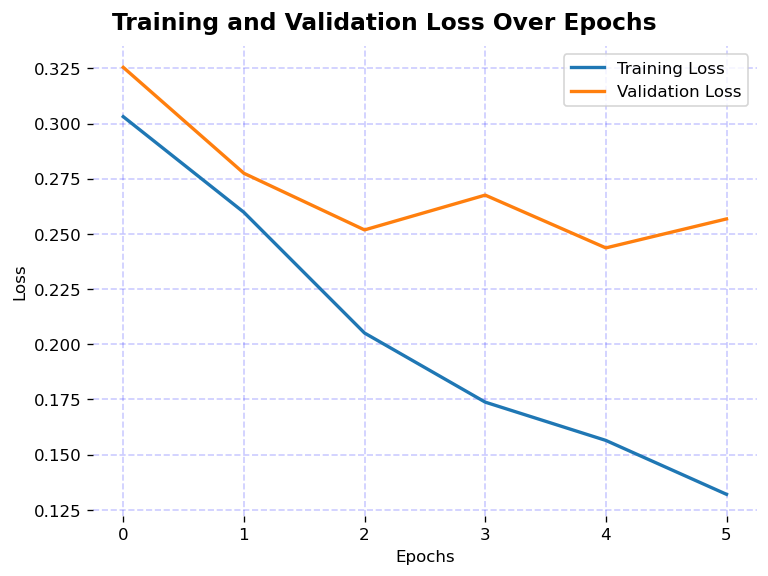

In [21]:
# Plotting
def plot_loss_curves(train_losses, val_losses):
    fig, ax = plt.subplots(figsize=(6.4, 4.8), dpi=120)
    fig.suptitle("Training and Validation Loss Over Epochs", fontsize=14, weight='bold')
    ax.plot(train_losses, linewidth=2, label='Training Loss')
    ax.plot(val_losses, linewidth=2, label='Validation Loss')
    ax.set_xticks(np.arange(0, len(train_losses), 1))
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.grid(color='blue', linestyle='--', linewidth=1, alpha=0.2)
    ax.legend(loc="upper right")
    spines = ['top', 'right', 'bottom', 'left']
    for s in spines:
        ax.spines[s].set_visible(False)
    fig.tight_layout(pad=0.7)
    plt.show()

plot_loss_curves(train_losses, val_losses)

## 7. Evaluate Accuracy in PyTorch

Writing a function to calculate the accuracy. We'll use this function with our validation dataset.
#### Accuracy Calculation Function

In [22]:
def evaluate_accuracy(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computation during inference
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

Using the function to evaluate Validation Accuracy:

In [23]:
model.eval()  # Set the model to evaluation mode
valid_accuracy = evaluate_accuracy(model, validloader)
print(f'\nValidation Accuracy: {valid_accuracy:.2f}%')


Validation Accuracy: 91.77%


#### Explanation of Accuracy in Image Classification

Accuracy is a key metric in image classification that quantifies how often a model correctly predicts the label of an image. It's expressed as the percentage of test images correctly classified by the model.

Mathematically, accuracy is defined as the ratio of correct predictions to total predictions:
$$
\text{Accuracy}=\frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
$$

Alternatively, using terms from confusion matrix:
$$
\text{Accuracy}=\frac{TP+TN}{TP+TN+FP+FN}
$$

Where:
- **TP (True Positives):** Images correctly identified as belonging to a class.
- **TN (True Negatives):** Images correctly identified as not belonging to a class.
- **FP (False Positives):** Images incorrectly identified as belonging to a class.
- **FN (False Negatives):** Images incorrectly identified as not belonging to a class.

In multi-class settings, such as the Fashion MNIST dataset with 10 classes, accuracy is typically calculated as the ratio of correct predictions to total predictions. The use of TP, TN, FP, FN becomes more relevant in binary classification.

## 8. Making Predictions

After training your model in PyTorch, you can use it to make predictions on new data. PyTorch models output the logits directly, and you can apply a softmax function to convert these logits into probabilities for easier interpretation.

In [24]:
# Function to make predictions
def make_predictions(model, test_images):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient tracking
        logits = model(test_images)
        probabilities = F.softmax(logits, dim=1)
        return probabilities

# Make predictions
predictions = make_predictions(model, valid_images)

### 8.1 Interpreting Predictions

Each prediction is an array of 10 elements when working with the Fashion MNIST dataset, corresponding to the model's confidence for each of the 10 classes.

In [25]:
# Look at the first prediction
first_prediction = predictions[0]
print(first_prediction)

# Find the class with the highest confidence for the first prediction
predicted_class = torch.argmax(first_prediction)
print(f"Predicted class: {predicted_class.item()}")

# Compare with the actual label
actual_label = valid_labels[0]
print(f"Actual label: {actual_label}")

tensor([6.5018e-08, 1.0000e+00, 1.1627e-10, 3.9829e-08, 5.4289e-10, 1.7141e-13,
        4.4465e-09, 7.4519e-16, 3.9247e-12, 4.0176e-14])
Predicted class: 1
Actual label: 1


#### Key Points:

- **Softmax Transformation:** Applying softmax to the logits converts them into probabilities, which sum up to 1. This makes the model's outputs more interpretable as confidence scores for each class.

- **Disabling Gradient Tracking:** Since we're only making predictions and not training the model, we disable gradient tracking with `torch.no_grad()`, which reduces memory usage and speeds up computations.

- **Model Evaluation Mode:** It's crucial to set the model to evaluation mode (`model.eval()`) before making predictions to ensure layers like dropout and batch normalization work in inference mode.

- **Predictions:** The predictions are tensors containing the probability of each class. The class with the highest probability is considered the model's prediction.

### 8.2 Verify Predictions

With the model trained, you can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

In [26]:
import matplotlib.pyplot as plt

def plot_image(i, predictions_array, true_label, img, class_names):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.squeeze(), cmap=plt.cm.binary)  # Assuming img is a PyTorch Tensor

    predicted_label = torch.argmax(predictions_array).item()
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(
        class_names[predicted_label],
        100 * torch.max(predictions_array).item(),
        class_names[true_label]),
        color=color
    )

def plot_value_array(i, predictions_array, true_label, class_names):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    predictions_array = predictions_array.numpy()
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

Now, let's use these functions to visualize the model's predictions. We'll plot both the image and its prediction probability distribution:

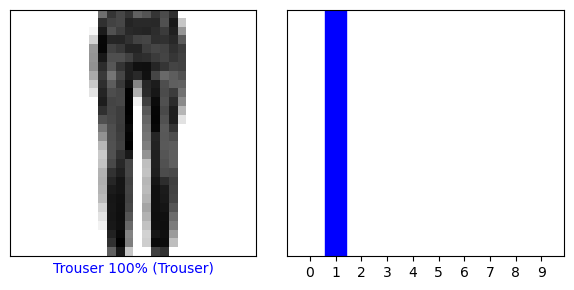

In [27]:
# Example: Visualizing the first image and its prediction
def plot_single_image_prediction(img_number):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(img_number, predictions[img_number], valid_labels, valid_images, class_names)
    plt.subplot(1,2,2)
    plot_value_array(img_number, predictions[img_number], valid_labels, class_names)
    plt.tight_layout()
    plt.show()

plot_single_image_prediction(img_number=0)

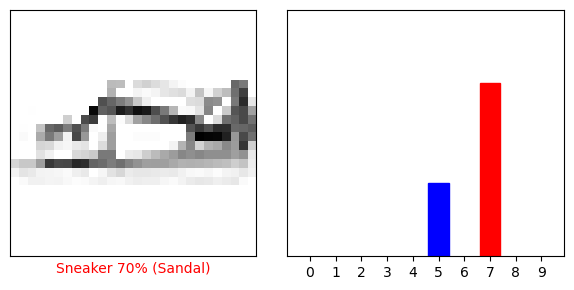

In [28]:
plot_single_image_prediction(img_number=12)

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

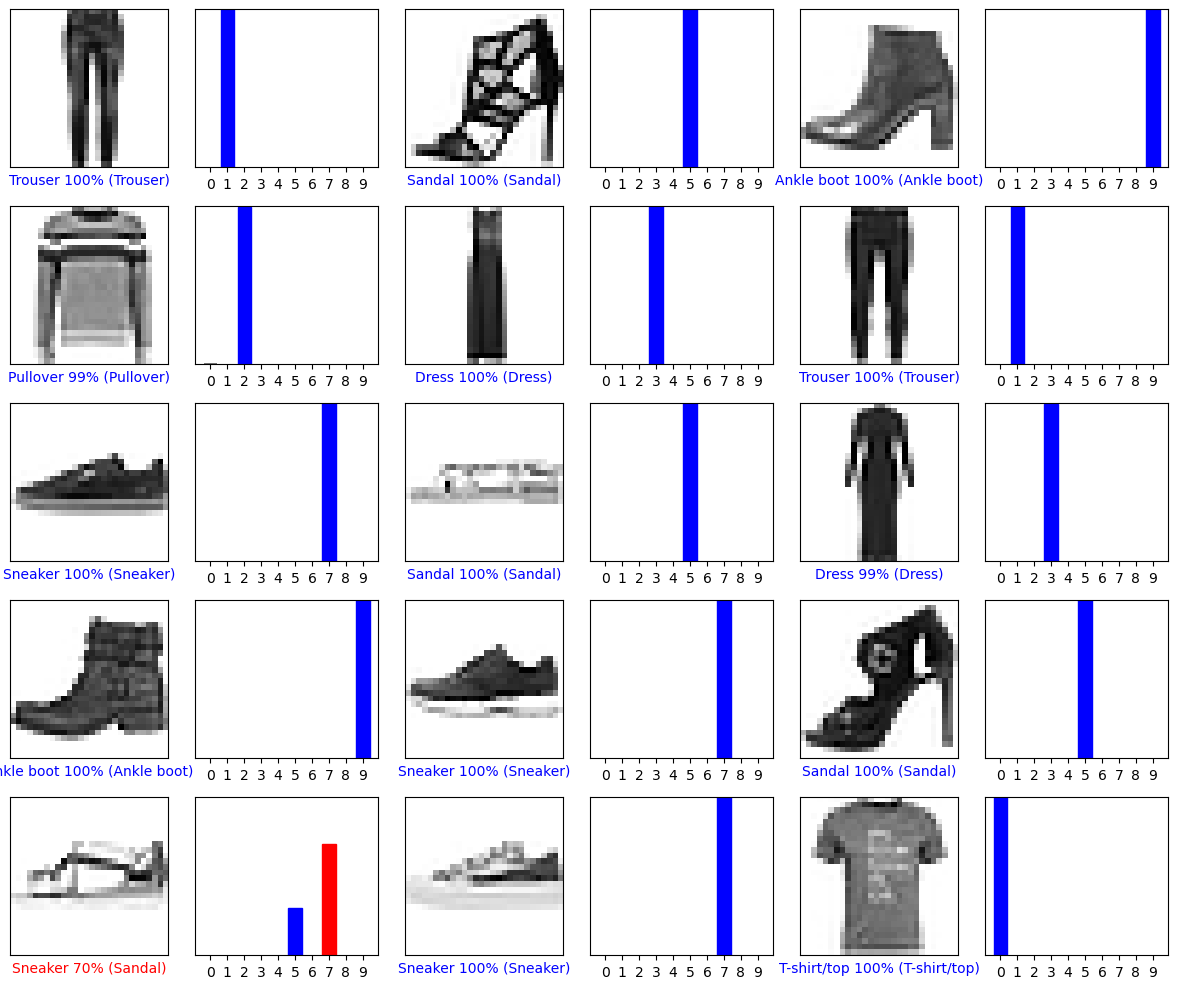

In [29]:
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], valid_labels, valid_images, class_names)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i, predictions[i], valid_labels, class_names)
plt.tight_layout()
plt.show()


## 9. Loading a Trained Model

After training your model and saving its state, you can load the model for further inference, evaluation, or continued training. To load a saved model, you'll need to:

- **Recreate the Model Architecture:** Instantiate a new object of your model class. It's important that this new model has the same architecture as the one you trained.

- **Load the Saved State Dictionary:** Use `torch.load()` to load the saved state dictionary, and then load this state into your newly created model using `model.load_state_dict()`.

- **Documentation:** [Saving and Loading models using PyTorch](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

Here's an example:

In [30]:
import os

# Step 1: Instantiate the model
loaded_model = CNNClassifier()

# Step 2: Find the latest model file
model_dir = './saved_models'
model_files = [os.path.join(model_dir, f) for f in os.listdir(model_dir) if f.endswith('.pth')]
latest_model_file = max(model_files, key=os.path.getctime)

# Step 3: Load the saved state dictionary
loaded_model.load_state_dict(torch.load(latest_model_file))

# Step 4: Switch the model to evaluation mode for inference
loaded_model.eval()

print(f"Loaded model from {latest_model_file}")

Loaded model from ./saved_models/model_4_20240122_074537.pth


### 7.1 Test Loaded Model

We can use the loaded model for inference:

In [31]:
valid_accuracy = evaluate_accuracy(loaded_model, validloader)
print(f'\nValidation Accuracy: {valid_accuracy:.2f}%')


Validation Accuracy: 91.71%


## 10. Challenge: Can You Build a Better CNN?

As we conclude this demo, I want to leave you with a challenge that will not only test what you've learned but also push the boundaries of your skills in computer vision and deep learning.

#### Your Mission: Outperform My Model

I've walked you through building and training a Convolutional Neural Network (CNN) that achieved a 91% accuracy on the Fashion MNIST dataset. Now, it's your turn to take the reins. Can you construct and train a CNN that surpasses this benchmark?

**Tips for Improvement:**

- **Experiment with Architecture:** Try adding more convolutional layers, or adjust the number of neurons in the dense layers. Introduce layers like Dropout or Batch Normalization to see if they help in achieving better generalization.

- **Tune Hyperparameters:** Play around with different learning rates, batch sizes, or optimization algorithms. Sometimes, small changes in these parameters can lead to significant improvements.

- **Data Augmentation:** Use techniques like rotation, scaling, or horizontal flipping to artificially expand your training dataset. This can often help improve the robustness of your model.

- **Advanced Techniques:** If you're feeling adventurous, explore more advanced architectures like ResNets or Capsule Networks, or delve into newer regularization techniques.

#### Share Your Results!

Once you've built your model, evaluate it on the validation set to see if you've managed to outdo the 91% accuracy. 

Share your results, along with your unique approach and insights. This is a fantastic opportunity to engage with peers, exchange knowledge, and showcase your skills.